The purpose of this notebook is to ...





# General imports

In [1]:
# We need to import some Python libraries here first.

import os
import sys
import shutil
import scipy
import time
import glob

import numpy as np
import xarray as xr


from IPython.display import clear_output

In [2]:
# We need import pyFAI,PyQt5,ipympl packages (if not available pip-install)


try:
    import ipympl
except:
    !! pip install ipympl

# if running on google colab
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

In [3]:
try:
    %matplotlib widget
except:
    %matplotlib inline

# importing matplotlib for plots.
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.constrained_layout.use'] = True

# Setting up the example data path

In [4]:
# We assume this notebook and its data is on Google Drive so that we can use Google Colab.
# Otherwise, replace example_data_path with the path the notebook and its data folder are stored on

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/SULI-2024/repositories/pySULI/notebooks/')
    from google.colab import output
    output.enable_custom_widget_manager()

except:
    pass

In [5]:
# Assuming notebook and data folder are here.

here = os.getcwd()
example_data_path = 'example_data/xrd_refinement_with_gsas2/'

os.chdir('%s/%s'%(here,example_data_path))
os.listdir()

['gsas2_package',
 'Background.nc',
 'gsas.instprm',
 'Pt.nc',
 'ZrH.nc',
 'ZrH.gpx',
 'Zr-H1.66.cif',
 'Zr.cif',
 'Pt.cif',
 'LaB6.gpx',
 'Pt.gpx',
 'gsas2_scratch',
 'LaB6.nc',
 'LaB6.cif',
 'Ceo2.cif',
 'gsas2_package_v5038.zip']

In [6]:
ls

Background.nc   gsas2_package_v5038.zip  LaB6.cif  Pt.cif  Zr.cif        ZrH.nc
Ceo2.cif        gsas2_scratch/           LaB6.gpx  Pt.gpx  Zr-H1.66.cif
gsas2_package/  gsas.instprm             LaB6.nc   Pt.nc   ZrH.gpx


# Setting up GSAS-II package and custom refinement functions

In [16]:
# assuming GSAS-II is installed on the machine on conda
# as explained here: https://advancedphotonsource.github.io/GSAS-II-tutorials/install.html
# as a result of "conda create -n GSASII briantoby::gsas2pkg  -c conda-forge", GSAS-II
# will be installed on a eng location. Then we add it to path as below.

import sys
sys.path += ['/home/mt/software/miniforge3/envs/GSASII/GSAS-II/GSASII']

# we then import GSASIIscriptable
import GSASIIscriptable as G2sc
import pybaselines # this comes with gsas2_package

from IPython.display import clear_output

# clear_output()

In [8]:

def twotheta_to_q(twotheta, wavelength):
    twotheta = np.asarray(twotheta)
    wavelength = float(wavelength)
    pre_factor = ((4 * np.pi) / wavelength)
    return pre_factor * np.sin(twotheta / 2)
def q_to_twotheta(q, wavelength):
    q = np.asarray(q)
    wavelength = float(wavelength)
    pre_factor = wavelength / (4 * np.pi)
    return 2 * np.arcsin(q * pre_factor)
def q_to_d(q):
    return (2 * np.pi) / np.asarray(q)
def d_to_q(d):
    return (2 * np.pi) / np.asarray(d)
def twotheta_to_d(twotheta,wavelength):
    th = np.asarray(twotheta)/2
    rad = np.radians(th)
    t = 2*np.sin(rad)
    d = (wavelength)/t
    return d
def tth_wl1_to_wl2(tth1,wl1=0.187,wl2=0.4592):
    """
    scales TwoTheta1 with wavelength1 to TwoTheta1 with wavelength2
    """
    q = twotheta_to_q(np.deg2rad(tth_in), wl1)
    return np.rad2deg(q_to_twotheta(q,wl2))



# GSAS-II functions (incomplete)
# See for more info https://gsas-ii.readthedocs.io/en/latest/GSASIIscriptable.html#

def PrintwR(gpx,header=''):
    clear_output()
    hist   = gpx.histograms()[0]
    print('\n'+header)
    print("\t{:20s}: {:.2f}".format(hist.name,hist.get_wR()))
    print("")


# def set_limits(gpx,limits=None):
#     gpx.set_refinement({"set":{'Limits': limits}})
#     gpx.save()
#     print('\nlimits are set\n ')

def set_LeBail(gpx,LeBail=False):
    gpx.set_refinement({"set":{'LeBail': LeBail}})
    gpx.save()
    print('\nLeBail is set to %s\n '%(LeBail))


def refine_background(gpx,num_coeffs,set_to_false=True):
    try:
        rwp_old = gpx['Covariance']['data']['Rvals']['Rwp']
    except:
        rwp_old = 'na'

    ParDict = {'set': {'Background': {'refine': True,
                                      'type': 'chebyschev-1',
                                      'no. coeffs': num_coeffs
                                     }}}
    gpx.set_refinement(ParDict)

    gpx.refine(); rwp_new = gpx['Covariance']['data']['Rvals']['Rwp']

    if set_to_false:
        gpx.set_refinement({'set': {'Background': {'refine': False}}})
    gpx.save()

    try:
        print('\n\n\nBackground is refined: Rwp=%.3f (was %.3f)\n\n\n '%(rwp_new,rwp_old))
    except:
        print('\n\n\nBackground is refined: Rwp=%.3f \n\n\n '%(rwp_new))


def refine_cell_params(gpx,phase_ind=None,set_to_false=True):
    rwp_old = gpx['Covariance']['data']['Rvals']['Rwp']
    phases = gpx.phases()
    for e,p in enumerate(phases):
        if phase_ind is None:
            gpx['Phases'][p.name]['General']['Cell'][0]= True
        else:
            if e == phase_ind:
                gpx['Phases'][p.name]['General']['Cell'][0]= True
    gpx.refine()
    if set_to_false:
        phases = gpx.phases()
        for p in phases:
            gpx['Phases'][p.name]['General']['Cell'][0]= False
    rwp_new = gpx['Covariance']['data']['Rvals']['Rwp']
    gpx.save()
    if phase_ind is None:
        print('\n\n\nCell parameters of all phases are refined simultaneously: Rwp=%.3f (was %.3f)\n\n\n '%(rwp_new,rwp_old))
    else:
        print('\n\n\nCell parameters of phase #d is refined: Rwp=%.3f (was %.3f)\n\n\n '%(phase_ind,rwp_new,rwp_old))


def refine_strain_broadening(gpx,set_to_false=True):
    rwp_old = gpx['Covariance']['data']['Rvals']['Rwp']
    ParDict = {'set': {'Mustrain': {'type': 'isotropic',
                                      'refine': True
                                     }}}
    gpx.set_refinement(ParDict)
    gpx.refine()

    if set_to_false:
        ParDict = {'set': {'Mustrain': {'type': 'isotropic',
                                  'refine': False
                                 }}}
    gpx.set_refinement(ParDict)
    gpx.refine()
    rwp_new = gpx['Covariance']['data']['Rvals']['Rwp']
    gpx.save()
    print('\n\n\nStrain broadeing is refined: Rwp=%.3f (was %.3f)\n\n\n '%(rwp_new,rwp_old))


def refine_size_broadening(gpx,set_to_false=True):
    rwp_old = gpx['Covariance']['data']['Rvals']['Rwp']
    ParDict = {'set': {'Size': {'type': 'isotropic',
                                      'refine': True
                                     }}}
    gpx.set_refinement(ParDict)
    gpx.refine()
    if set_to_false:
        ParDict = {'set': {'Size': {'type': 'isotropic',
                                  'refine': False
                                 }}}
    gpx.set_refinement(ParDict)
    gpx.refine()
    rwp_new = gpx['Covariance']['data']['Rvals']['Rwp']
    gpx.save()
    print('\nSize broadeing is refined: Rwp=%.3f (was %.3f)\n '%(rwp_new,rwp_old))


def refine_inst_parameters(gpx,inst_pars_to_refine=['X', 'Y', 'Z', 'Zero', 'SH/L', 'U', 'V', 'W'],set_to_false=True):
    rwp_old = gpx['Covariance']['data']['Rvals']['Rwp']
    gpx.set_refinement({"set": {'Instrument Parameters': inst_pars_to_refine}})
    gpx.refine()
    if set_to_false:
        ParDict = {"clear": {'Instrument Parameters': ['X', 'Y', 'Z', 'Zero', 'SH/L', 'U', 'V', 'W']}}
        gpx.set_refinement(ParDict)
        gpx.refine()
    rwp_new = gpx['Covariance']['data']['Rvals']['Rwp']
    gpx.save()
    print('\nInstrument parameters %s are refined: Rwp=%.3f (was %.3f)\n '%(inst_pars_to_refine,rwp_new,rwp_old))




def instprm_updater(gpx, gsas2_scratch='gsas2_scratch'):
    instprm_dict = gpx['PWDR data.xy']['Instrument Parameters'][0]
    with open('%s/gsas.instprm'%gsas2_scratch, 'w') as f:
        f.write('#GSAS-II instrument parameter file; do not add/delete items!\n')
        f.write('Type:PXC\n')
        f.write('Bank:1.0\n')
        f.write('Lam:%s\n'%(instprm_dict['Lam'][1]))
        f.write('Polariz.:%s\n'%(instprm_dict['Polariz.'][1]))
        f.write('Azimuth:%s\n'%(instprm_dict['Azimuth'][1]))
        f.write('Zero:%s\n'%(instprm_dict['Zero'][1]))
        f.write('U:%s\n'%(instprm_dict['U'][1]))
        f.write('V:%s\n'%(instprm_dict['V'][1]))
        f.write('W:%s\n'%(instprm_dict['W'][1]))
        f.write('X:%s\n'%(instprm_dict['X'][1]))
        f.write('Y:%s\n'%(instprm_dict['Y'][1]))
        f.write('Z:%s\n'%(instprm_dict['Z'][1]))
        f.write('SH/L:%s\n'%(instprm_dict['SH/L'][1]))





def refiner(nc_path,
            phases,  # should be a dict like [{'cif_abs_path':'/content/drive/MyDrive/XRD-on-colab/_cifs/LaB6.cif','phase_name':'LaB6'}]
            da_input_bkg=None,
            q_range=[0.1, 10.1],
            gsas2_scratch  = 'gsas2_scratch',
            refinement_recipe = None,
            update_ds = True,
            update_gpx=True,
            plot=True
            ):


    if not os.path.isfile('%s/gsas.instprm'%gsas2_scratch):
        print('ERROR:!! gsas.instprm is not found. Please copy one into %s folder.\n\n'%gsas2_scratch)
        return


    with xr.open_dataset(nc_path) as ds:


        for k in ['Y_obs','Y_calc','Y_bkg_auto','Y_bkg_gsas','Y_bkg','Y_bkg_arpls','Y_bkg_auto']:
            if k in ds.keys():
                del ds[k]

        da_i2d = ds.i2d.sel(radial=slice(q_range[0],q_range[1])).astype('float32')
        da_i2d_m = da_i2d.mean(dim='azimuthal')


        if da_input_bkg is None:
            arpls_ = pybaselines.Baseline(x_data=da_i2d_m.radial.values).arpls((da_i2d_m).values, lam=1e5)[0]
            shift_ = min((da_i2d_m).values - arpls_)
            bkg_arpls = (arpls_+shift_)
            bkg_auto = bkg_arpls

        else:
            da_input_bkg = da_input_bkg.sel(radial=slice(q_range[0],q_range[1]))
            blank_scale = (da_i2d_m[0] / da_input_bkg[0]).values
            while (min((da_i2d_m.values-blank_scale*da_input_bkg.values)) < 0):
                blank_scale = blank_scale*0.95

            da_input_bkg_scaled = blank_scale*da_input_bkg

            arpls_ = pybaselines.Baseline(x_data=da_i2d_m.radial.values).arpls((da_i2d_m-da_input_bkg_scaled).values, lam=1e5)[0]
            shift_ = min((da_i2d_m-da_input_bkg_scaled).values - arpls_)
            bkg_arpls = (arpls_+shift_)
            bkg_auto = bkg_arpls + da_input_bkg_scaled.values


        Y_to_gsas = da_i2d_m.values-bkg_auto
        y_scale = 1000/max(Y_to_gsas)
        y_baseline = 10
        Y_to_gsas = y_baseline+Y_to_gsas*y_scale

        X_to_gsas = np.rad2deg(q_to_twotheta(da_i2d_m.radial.values, wavelength=(ds.attrs['wavelength']*1.0e10)))
        np.savetxt('%s/data.xy'%gsas2_scratch, np.column_stack( (X_to_gsas,Y_to_gsas) ), fmt='%.4f %.4f')


        # gpx part
        gpx = G2sc.G2Project(newgpx='%s/gsas.gpx'%gsas2_scratch)
        gpx.data['Controls']['data']['max cyc'] = 100
        gpx.add_powder_histogram('%s/data.xy'%gsas2_scratch,'%s/gsas.instprm'%gsas2_scratch)

        hist   = gpx.histograms()[0]
        for p in phases:
            gpx.add_phase(p['cif_abs_path'],phasename=p['phase_name'], histograms=[hist],fmthint='CIF')
        gpx.save()

        gpx = refinement_recipe(gpx)


        histogram = gpx.histograms()[0]

        gsas_X  = histogram.getdata('x').astype('float32')
        gsas_Yo = histogram.getdata('yobs').astype('float32')
        gsas_Yc = histogram.getdata('ycalc').astype('float32')
        gsas_B  = histogram.getdata('Background').astype('float32')



        # now convert Y back
        Y_Obs_from_gsas  = ((gsas_Yo -y_baseline  )/y_scale )
        Y_Bkg_from_gsas  = ((gsas_B  -y_baseline  )/y_scale )
        Y_calc_from_gsas = ((gsas_Yc -y_baseline  )/y_scale ) # this also includes background from GSAS


        ds = ds.assign_coords(
            {"X_in_q": da_i2d_m.radial.values.astype('float32')},
            )
        ds = ds.assign_coords(
            {"X_in_tth": gsas_X.astype('float32')},
            )
        ds = ds.assign_coords(
            {"X_in_d": q_to_d(da_i2d_m.radial.values.astype('float32'))},
            )


        ds['Y_obs'] = xr.DataArray(
                                    data=da_i2d_m.values,
                                    dims=['X_in_q'],
                                )
        ds['Y_calc'] = xr.DataArray(
                                    data=Y_calc_from_gsas-Y_Bkg_from_gsas,
                                    dims=['X_in_q'],
                                )# by Ycalc, we mean only calculated peaks, no background

        ds['Y_bkg_gsas'] = xr.DataArray(
                                    data=Y_Bkg_from_gsas,
                                    dims=['X_in_q'],
                                )
        ds['Y_bkg_auto'] = xr.DataArray(
                                    data=bkg_auto,
                                    dims=['X_in_q'],
                                )



        with open('%s/gsas.lst'%(gsas2_scratch)) as lst_file:
            gsas_lst = lst_file.read()
            ds.attrs['gsas_lst'] = gsas_lst


    # for e,p in enumerate(gpx.phases()):
    #     p.export_CIF(outputname='%s/%s_from_refinement.cif'%(gsas2_scratch,p.name))
    #     with open('%s/%s_from_refinement.cif'%(gsas2_scratch,p.name)) as cif_file:
    #         ds.attrs['%s_refined_structure'%(p.name)] = cif_file.read()
    #     os.remove('%s/%s_from_refinement.cif'%(gsas2_scratch,p.name))


    if update_ds:
        ds.to_netcdf(nc_path+'.new.nc',engine="scipy")
        time.sleep(0.1)
        shutil.move(nc_path+'.new.nc',nc_path)


    if update_gpx:
        shutil.copyfile(gpx['Controls']['data']['LastSavedAs'],'%s.gpx'%nc_path[:-3])


    if plot:
        fig = plt.figure(figsize=(8,8),dpi=96)
        mosaic = """
        RRR
        YYY
        YYY
        DDD
        """
        ax_dict = fig.subplot_mosaic(mosaic)

        ax = ax_dict["R"]

        np.log(da_i2d).plot.imshow(ax=ax,robust=True,add_colorbar=False,cmap='Greys',vmin=0)
        ax.set_ylabel(ds.i2d.ylabel)
        ax.set_xlabel(None)
        ax.set_xticklabels([])
        ax.set_xlim([q_range[0],q_range[1]])
        Rwp, GoF = gpx.data['Covariance']['data']['Rvals']['Rwp'], gpx.data['Covariance']['data']['Rvals']['GOF']
        ax.set_title('%s\n(R$_{wp}$=%.3f GoF=%.3f)'%(nc_path.split('/')[-1],Rwp,GoF))
        ax.set_facecolor('#FFFED4')

        ax = ax_dict["Y"]
        X, Yobs, Ycalc, Ybkg= ds['X_in_q'].values, ds['Y_obs'].values, ds['Y_calc'].values, (ds['Y_bkg_auto']+ds['Y_bkg_gsas']).values
        ax.plot(X, np.log( Yobs ),label='Y$_{obs}$',lw=2,color='k')
        ax.plot(X, np.log( Ycalc+Ybkg ),label='Y$_{calc}$+Y$_{bkg}$',lw=1,color='y')
        ax.fill_between(X, np.log( Ybkg ),label='Y$_{bkg}$',alpha=0.2)
        ax.set_ylim(bottom=np.log(min(min(Ybkg),min(Ybkg)))-0.1)
        ax.set_xticklabels([])
        ax.set_ylabel('Log$_{10}$(counts) (a.u.)')
        ax.set_xlim([q_range[0],q_range[1]])
        ax.legend(loc='best')

        ax = ax_dict["D"]
        ax.plot(X, Yobs-Ycalc-Ybkg,label='diff.',lw=1,color='r')
        ax.set_xlabel('Scattering vector $q$ ($\AA^{-1}$)')
        ax.set_ylabel('counts (a.u.)')
        ax.set_xlim([q_range[0],q_range[1]])
        ax.legend(loc='best')


    return [gpx,ds]





# Refinements

In [9]:
os.makedirs('gsas2_scratch',exist_ok=True)

In [10]:
%%writefile gsas2_scratch/gsas.instprm
#GSAS-II instrument parameter file; do not add/delete items!
Type:PXC
Bank:1.0
Lam:0.1824
Polariz.:7.277695011573669
Azimuth:0.0
Zero:-0.00025200085768731445
U:129.15268004188428
V:1.816645496453032
W:0.43034683098418736
X:-0.0661572816525536
Y:-0.9270864296622138
Z:0.02775503495558348
SH/L:0.002

Overwriting gsas2_scratch/gsas.instprm


In [11]:
with xr.open_dataset('Background.nc') as ds:
    da_input_bkg = ds.i2d.mean(dim='azimuthal')

ImportError for wx/mpl in GSASIIctrlGUI: ignore if docs build

Import_Powder_Data: Error importing file /home/mt/software/miniforge3/envs/GSASII/GSAS-II/GSASII/imports/G2pwd_BrukerRAW.py
Error message: No module named 'wx'

ImportError for wx/mpl in GSASIIctrlGUI: ignore if docs build
MIDAS_Zarr Reader skipped because zarr module is not installed
ImportError for wx/mpl in GSASIIctrlGUI: ignore if docs build

Import_Powder_Data: Error importing file /home/mt/software/miniforge3/envs/GSASII/GSAS-II/GSASII/imports/G2pwd_rigaku.py
Error message: No module named 'wx'

ImportError for wx/mpl in GSASIIctrlGUI: ignore if docs build
ImportError for wx/mpl in GSASIIctrlGUI: ignore if docs build
ImportError for wx/mpl in GSASIIctrlGUI: ignore if docs build

Import_Phase: Error importing file /home/mt/software/miniforge3/envs/GSASII/GSAS-II/GSASII/imports/G2phase_rmc6f.py
Error message: No module named 'wx'

ImportError for wx/mpl in GSASIIctrlGUI: ignore if docs build

Export init: Error importin

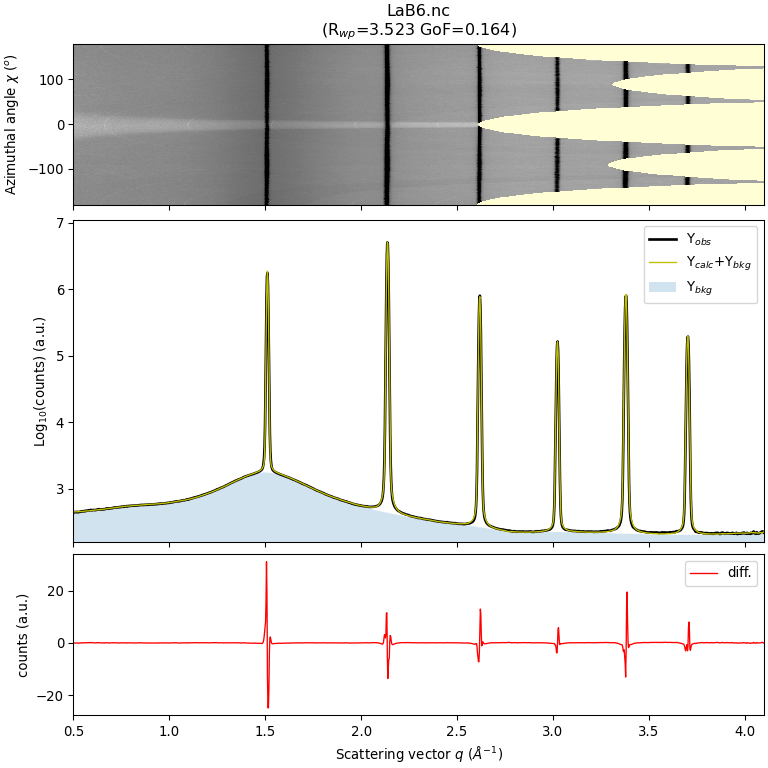

In [12]:
def refinement_recipe(gpx,update_instprm=True):

    refine_background(gpx,num_coeffs=2,set_to_false=True)
    set_LeBail(gpx,LeBail=True)
    refine_cell_params(gpx,set_to_false=True)
    # refine_size_broadening(gpx,set_to_false=True)
    # refine_strain_broadening(gpx,set_to_false=True)

    for par in ['U', 'V', 'W']:
        refine_inst_parameters(gpx,inst_pars_to_refine=[par])
    for par in ['X', 'Y', 'Z']:
        refine_inst_parameters(gpx,inst_pars_to_refine=[par])
    for par in ['Zero']:
        refine_inst_parameters(gpx,inst_pars_to_refine=[par])
    if update_instprm:
        instprm_updater(gpx)
    gpx.save()

    refine_background(gpx,num_coeffs=10,set_to_false=True)
    refine_cell_params(gpx,set_to_false=True)


    return gpx





nc_path = 'LaB6.nc'

phases = [
    {'cif_abs_path':'LaB6.cif','phase_name':'LaB6'},
    ]



[gpx,ds] = refiner(nc_path,
            phases,
            da_input_bkg=da_input_bkg,
            q_range=[0.5,4.1],
            gsas2_scratch  = 'gsas2_scratch',
            refinement_recipe = refinement_recipe,
            update_ds = True
            )


In [13]:
1/3

0.3333333333333333

/home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/gsas2_scratch/data.xy read by Reader comma/tab/semicolon separated
Instrument parameters read: /home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/gsas2_scratch/gsas.instprm (G2 fmt) bank None
/home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/Pt.cif read by Reader CIF
gpx file saved as /home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/gsas2_scratch/gsas.gpx
gpx file saved as /home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/gsas2_scratch/gsas.gpx
gpx file saved as /home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/gsas2_scratch/gsas.gpx
 Hessian Levenberg-Marquardt SVD refinement on 6 variables:
initial chi^2 1.0898e+10 with 1440 obs.
Cycle 0: 0.02s, Chi**2: 1253.7 for 1440 obs., Lambda: 0,  Delta: 1, SVD=0
Cycle 1: 0.02s, Chi**2: 1253.7 for 1440 obs., Lambda: 0,  Delta: 0, SVD=0
converged
Ma

/home/mt/software/miniforge3/envs/menv/lib/python3.11/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


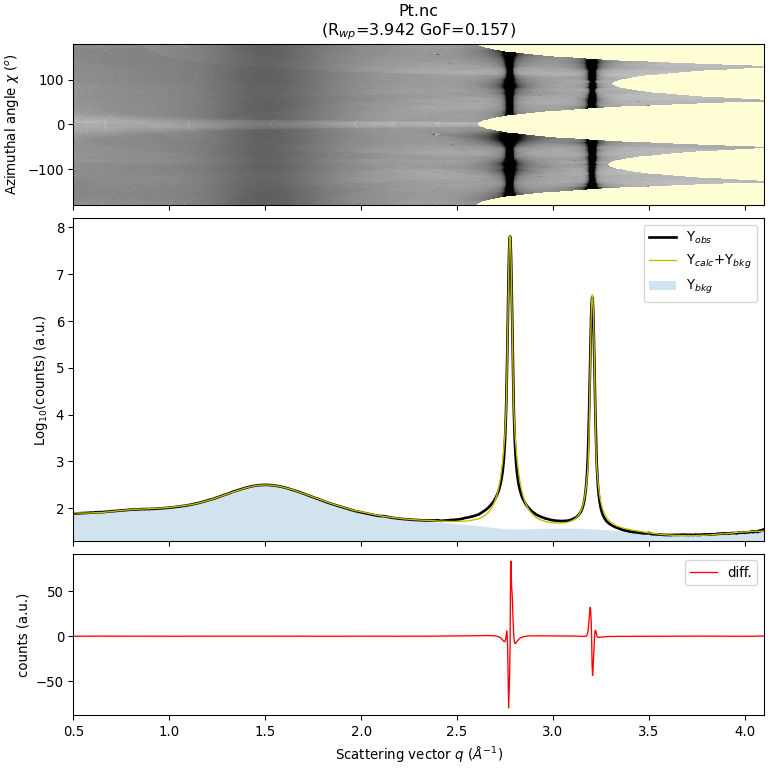

In [14]:
def refinement_recipe(gpx):

    refine_background(gpx,num_coeffs=5,set_to_false=True)
    set_LeBail(gpx,LeBail=True)
    refine_cell_params(gpx,set_to_false=True)
    refine_size_broadening(gpx,set_to_false=True)
    refine_strain_broadening(gpx,set_to_false=True)
    refine_background(gpx,num_coeffs=10,set_to_false=True)

    gpx.save()
    return gpx


nc_path = 'Pt.nc'

phases = [
    {'cif_abs_path':'Pt.cif','phase_name':'Pt'},
    ]

[gpx,ds] = refiner(nc_path,
            phases,
            da_input_bkg=da_input_bkg,
            q_range=[0.5,4.1],
            gsas2_scratch  = 'gsas2_scratch',
            refinement_recipe = refinement_recipe,
            update_ds = True
            )

/home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/gsas2_scratch/data.xy read by Reader comma/tab/semicolon separated
Instrument parameters read: /home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/gsas2_scratch/gsas.instprm (G2 fmt) bank None
/home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/Pt.cif read by Reader CIF
gpx file saved as /home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/gsas2_scratch/gsas.gpx
/home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/Zr.cif read by Reader CIF
gpx file saved as /home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/gsas2_scratch/gsas.gpx
gpx file saved as /home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/gsas2_scratch/gsas.gpx
gpx file saved as /home/mt/temp/3_Wd/pySULI/notebooks/example_data/xrd_refinement_with_gsas2/gsas2_scratch/gsas.gpx
 Hessian Levenberg-Marquardt SVD refinement

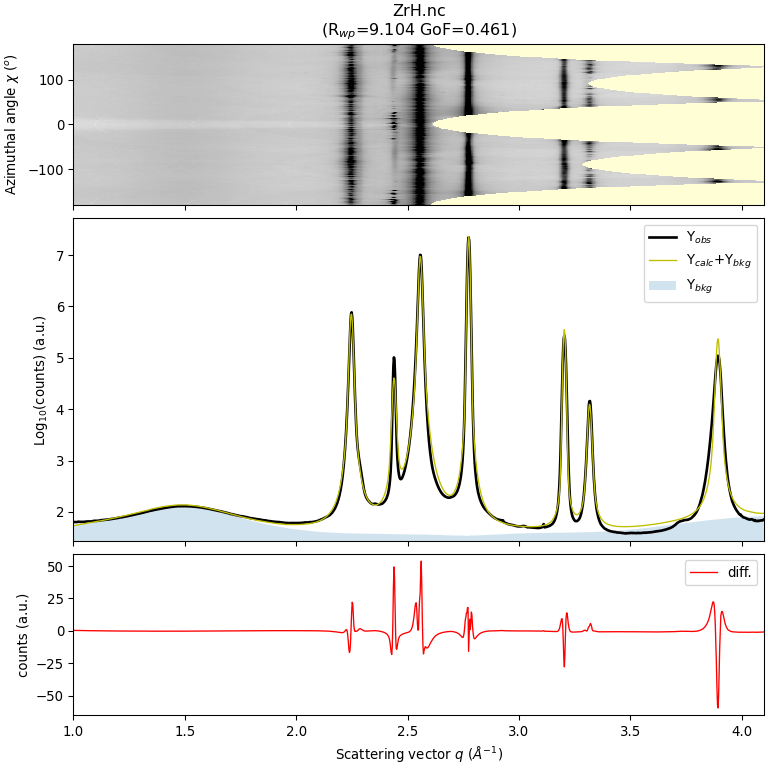

In [15]:
def refinement_recipe(gpx):

    refine_background(gpx,num_coeffs=3,set_to_false=True)
    set_LeBail(gpx,LeBail=True)
    refine_cell_params(gpx,set_to_false=True)
    refine_size_broadening(gpx,set_to_false=True)
    refine_strain_broadening(gpx,set_to_false=True)
    refine_background(gpx,num_coeffs=5,set_to_false=True)
    refine_cell_params(gpx,set_to_false=True)
    refine_size_broadening(gpx,set_to_false=True)
    refine_strain_broadening(gpx,set_to_false=True)

    gpx.save()
    return gpx



nc_path = 'ZrH.nc'

phases = [
    {'cif_abs_path':'Pt.cif','phase_name':'Pt'},
    {'cif_abs_path':'Zr.cif','phase_name':'Zr'},
    ]



[gpx,ds] = refiner(nc_path,
            phases,
            da_input_bkg=da_input_bkg,
            q_range=[1,4.1],
            gsas2_scratch  = 'gsas2_scratch',
            refinement_recipe = refinement_recipe,
            update_ds = True
            )
